In [1]:
!pip install neural_tangents

     |████████████████████████████████| 125 kB 4.2 MB/s 


In [4]:
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random
from jax.experimental import optimizers
from jax import jit, grad, vmap
from jax.config import config
from jax.experimental.ode import odeint
config.update("jax_enable_x64", True)
import neural_tangents as nt
from neural_tangents import stax

import urllib.request
import os
dir_data = os.path.join(os.getcwd(),'experiment_data_fixed_test.npz')
url = "https://raw.github.com/Pehlevan-Group/kernel-ood-generalization/main/experiment_data_fixed_test.npz"
urllib.request.urlretrieve(url, dir_data)

def ensure_dir(file_path):
    import os
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
root_dir = "paper_figures/"
ensure_dir(root_dir)

## Define Functions to Compute Theoretical Learning Curves

In [5]:
softmax = jit(lambda a: jnp.exp(a) / jnp.exp(a).sum())

@jit
def func(kappa, t, params):
    P, lamb, eigs = params
    return lamb + kappa * jnp.sum( eigs / (eigs * P + kappa) ) - kappa

@jit
def solve_kappa(P, lamb, eigs):
    return odeint(func, lamb, jnp.linspace(0.0,250.0, 250), (P,lamb, eigs))[-1]

@jit
def Eg_wrt_train(a, params):
    K, y, P, lamb = params
    sm = softmax(a)

    ## Eigendecomposition of training kernel
    eigs, phi0 = jnp.linalg.eigh(jnp.diag(jnp.sqrt(sm)) @ K @ jnp.diag(jnp.sqrt(sm)))
    phi0 = jnp.linalg.pinv(jnp.diag(jnp.sqrt(sm))) @ phi0

    # Compute O wrt uniform distribution
    O = 1/phi0.shape[0]*phi0.T @ phi0

    coeffs = (jnp.diag(sm)@phi0).T @ y

    kappa = solve_kappa(P, lamb, eigs)
    gamma = P * jnp.sum( eigs**2 / (eigs* P + kappa)**2 )
    Eg_old = kappa**2 / (1-gamma) * jnp.sum( coeffs**2 / (eigs*P + kappa)**2 )

    f = jnp.sum(jnp.diag(O) * eigs**2/(eigs*P + kappa)**2)/jnp.sum(eigs**2/(eigs*P + kappa)**2)

    G_mid = kappa / (kappa + eigs * P) * coeffs
    Eg = Eg_old * f + jnp.dot(G_mid , (O - f*jnp.eye(O.shape[0])) @ G_mid)

    return Eg

grad_wrt_train = jit(grad(Eg_wrt_train))

@jit
def get_O_tilde_wrt_train(a, params):
    K, y, P, lamb = params
    sm = softmax(a)

    eigs, phi0 = jnp.linalg.eigh(jnp.diag(jnp.sqrt(sm)) @ K @ jnp.diag(jnp.sqrt(sm)))
    phi0 = jnp.diag(1/jnp.sqrt(sm)) @ phi0

    # Compute O wrt uniform distribution
    O = 1/phi0.shape[0]*phi0.T @ phi0

    kappa = solve_kappa(P, lamb, eigs)
    gamma = P * jnp.sum(eigs**2 / (eigs*P + kappa)**2 )
    f = jnp.sum(jnp.diag(O) * eigs**2 / (eigs*P + kappa)**2)/jnp.sum(eigs**2/(eigs*P + kappa)**2)

    return O - (1-gamma*f)/(1-gamma)*jnp.eye(O.shape[0])


def kr_expt_measure_train(Pvals, prob_dist, K, y, lamb, num_repeat = 50):
    errs = np.zeros((len(Pvals), num_repeat))
    key = random.PRNGKey(0)
    for n in range(num_repeat):
        for i,P in enumerate(Pvals):
            _, key = random.split(key)
            #inds = jax.random.choice(key, a = int(K.shape[0]), shape = (int(P)) , p = prob_dist, replace = True)
            inds = np.random.choice(K.shape[0], int(P), p = prob_dist, replace = True)
            Ki = K[inds,:]
            Kii = Ki[:,inds]
            yi = y[inds]
            alpha = jnp.linalg.lstsq(Kii+lamb*np.eye(int(P)), yi)[0]
            yhat = Ki.T @ alpha
            errs[i,n] = np.mean((yhat - y)**2)
    return np.mean(errs, axis = 1), np.std(errs, axis = 1)


def nn_expt_measure_train(Pvals, prob_dist, init_fn, apply_fn, X, y):
    num_repeat = 10
    errs = np.zeros((len(Pvals), num_repeat))
    
    opt_init, opt_update, get_params = optimizers.adam(5e-2)
    get_params = jit(get_params)
    opt_update = jit(opt_update)
    
    for i,P in enumerate(Pvals):
        print('P = %d'%P)
        key = random.PRNGKey(0)
        for n in range(num_repeat):
            print('Trial %d'%(n + 1))
            key, subkey = random.split(key)
            _, params = init_fn(subkey, (-1, 784))
            opt_state = opt_init(params)

            inds = np.array(random.choice(subkey, K.shape[0], shape = (int(P),), p = prob_dist, replace = True))
            loss_fn = jit(lambda params: jnp.mean((apply_fn(params, X[inds]) - y[inds,jnp.newaxis])**2))
            g_loss = jit(grad(loss_fn))
            
            for t in range(1000):
                opt_state = opt_update(t, g_loss(get_params(opt_state)), opt_state)
                if t % 500 == 0:
                    print(loss_fn(get_params(opt_state)))

            yhat = np.array(apply_fn(get_params(opt_state), X))
            errs[i,n] = np.mean((yhat - y)**2)
    return np.mean(errs, axis = 1), np.std(errs, axis = 1)

def mnist_binary(N_tr, a, b, shuffle = False):
    from tensorflow import keras
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
  
    inds_binary_train = [i for i in range(len(y_train)) if y_train[i]==a or y_train[i]==b]
    inds_binary_test = [i for i in range(len(y_test)) if y_test[i]==a or y_test[i]==b]

    if shuffle:
        inds_binary_train = np.random.choice(inds_binary_train, size = N_tr, replace = False)
    else:
        inds_binary_train = inds_binary_train[:N_tr]

    x_train = x_train[inds_binary_train]
    y_train = y_train[inds_binary_train]
    x_train = x_train.reshape(N_tr, x_train.shape[1]*x_train.shape[2])
    x_train = x_train.T - np.mean(x_train, axis = 1)
    x_train = (x_train / np.linalg.norm(x_train, axis = 0)).T

    
    x_test = x_test[inds_binary_test]
    y_test = y_test[inds_binary_test]
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
    x_test = x_test.T - np.mean(x_test, axis = 1)
    x_test = (x_test / np.linalg.norm(x_test, axis = 0)).T

    y_train = 1.0*(y_train == a) - 1.0*(y_train == b)
    y_test = 1.0*(y_test == a) - 1.0*(y_test == b)

    return (x_train, y_train), (x_test, y_test)

## Download and Preprocess Data

In [6]:
def fully_connected(width,depth):
    layers = []
    for l in range(depth):
        layers += [stax.Dense(width), stax.Relu()]
    layers += [stax.Dense(1)]
    return stax.serial(*layers)

width=5000
depth = 2
# define a RELU neural tangent kernel
init_fn, apply_fn, kernel_fn = fully_connected(width, depth)
kernel_fn = jit(kernel_fn, static_argnums=(2,))
apply_fn = jit(apply_fn)

a = 9
b = 8
total_pts = 1000
(X, y_vec), (x_test, y_test) = mnist_binary(total_pts, a, b, shuffle = False)

X = jnp.array(X)
y_vec = jnp.array(y_vec)

K = kernel_fn(X, None, 'ntk')

print(y_vec.shape)

11501568/11490434 [==============================] - 0s 0us/step


(1000,)


# Perform Eigendecomposition to get Eigenvalues and Eigenvectors of the Kernel

### Run This code before optimizing:

In [7]:
eig0, phi0 = jnp.linalg.eigh(1/K.shape[0] * K)
phi0 = jnp.sqrt(K.shape[0]) * phi0
eig0 = jnp.abs(eig0)
psi0 =  phi0 @ jnp.diag(jnp.sqrt(eig0))
coeff_phi = 1/K.shape[0] * phi0.T @ y_vec
lamb = 1e-6
print("done precomputing")

done precomputing


# Optimize Test Measure for Fixed Training Measure
### Uncomment in order to run experiments or skip ahead for precomputed data.

In [8]:
# Pvals = [10.0, 25.0, 50.0, 100., 250., 500., 750., 1000.0]

# all_final = []
# all_losses = []
# all_part_ratios = []
# for i, P in enumerate(Pvals):
#     params = (K, y_vec, P, lamb)
#     opt_init, opt_update, get_params = optimizers.adam(0.075)
#     opt_update = jit(opt_update)
#     opt_state = opt_init(jnp.zeros(K.shape[0]))
#     #T = 40
#     T = 5000
#     losses = []
#     print("P = %d" % P)
#     part_ratios = []
#     for t in range(T):
#         losst = Eg_wrt_train(get_params(opt_state), params)
#         part_ratios += [1.0/(softmax(get_params(opt_state))**2 ).sum()]
#         if t % 100  == 0:
#             print("loss %0.5f | participation ratio = %0.5f" % (losst,  part_ratios[-1]))

#         g = grad_wrt_train(get_params(opt_state), params)
#         opt_state= opt_update(t, g , opt_state)
#         losses += [losst]
        
#         if t > 1500 and (np.mean(losses[-1000:]) - losses[-1]) < 1e-5 and np.std(losses[-1000:]) < 1e-6:
#             print('ended at: T = ', t, ' loss = ',losses[-1], ' part_ratio = ', part_ratios[-1])
#             break
    
#     all_final += [get_params(opt_state)]
#     all_losses += [losses]
#     all_part_ratios += [part_ratios]

# np.savez(root_dir+'fixed_test_train_better.npz', {'Pvals': np.array(Pvals), 'train_dist': np.array(all_final), 'losses': all_losses, 'part_ratios': all_part_ratios, 'train_epochs': T})

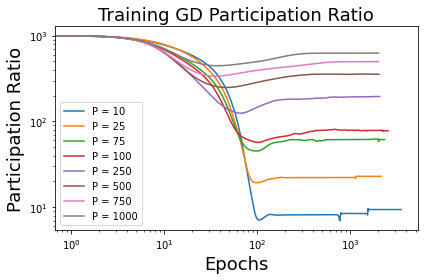

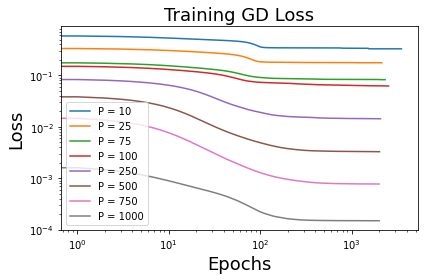

In [9]:
data = np.load(dir_data, allow_pickle=True)['arr_0'].tolist()

Pvals = data['Pvals']
all_train_dist = data['train_dist']
all_losses = data['losses']
all_part_ratios = data['part_ratios']

for part_ratio, loss, P in zip(all_part_ratios, all_losses, Pvals):
    plt.loglog(part_ratio, label='P = %d'%P)
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Participation Ratio', fontsize = 18)
plt.legend()
plt.title('Training GD Participation Ratio', fontsize = 18)
plt.tight_layout()
plt.savefig(root_dir+'fixed_test_part_ratio.png', dpi=300)
plt.show()


for part_ratio, loss, P in zip(all_part_ratios, all_losses, Pvals):
    plt.loglog(loss, label='P = %d'%P)
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.title('Training GD Loss', fontsize = 18)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir+'fixed_test_gd_loss.png', dpi=300)

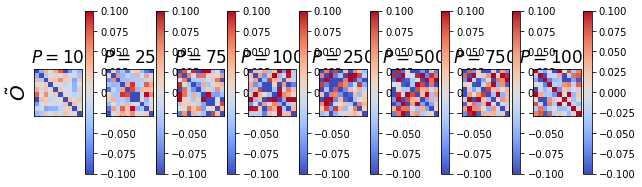

In [10]:
eigs = jnp.linalg.eigvalsh( 1/psi0.shape[0] * psi0.T @ psi0 )
indsort = jnp.argsort(eigs)[::-1]

plt.figure(figsize = (10,3))
for i, P in enumerate(Pvals):
    params = (K, y_vec, P, lamb)
    Oi = get_O_tilde_wrt_train(all_train_dist[i], params)[indsort,:]
    Oi = Oi[:,indsort]

    plt.subplot(1,len(Pvals), i+1)
    plt.imshow(Oi[0:10,0:10], vmin =-0.1, vmax = 0.1, cmap ='coolwarm')
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.title(r'$P = %d$' % P,fontsize=17)
    if i ==0:
        plt.ylabel(r'$\tilde{O}$',fontsize = 20)
plt.savefig(root_dir + 'tilde_O_vary_P_opt_train.pdf')
plt.show()

1.0000000000000002
0.9999999999999997
1.0
1.0000000000000002
0.9999999999999999
1.0000000000000002
1.0
1.0


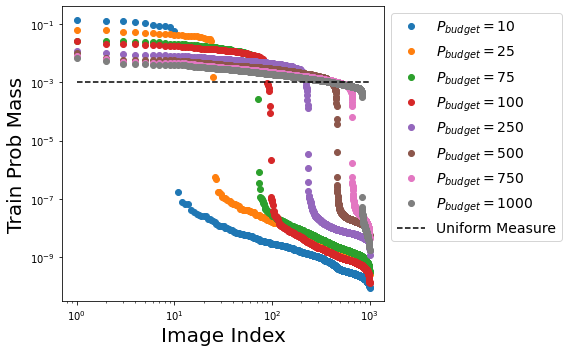

In [11]:
plt.figure(figsize = (8,5))

for i, P in enumerate(Pvals):
    plt.loglog(np.linspace(1,len(all_train_dist[i]), len(all_train_dist[i])), softmax(all_train_dist[i]).sort()[::-1], 'o' ,label =r'$P_{budget} = %d$' % P )
    print(softmax(all_train_dist[i]).sort()[::-1].sum())
    
plt.loglog(np.linspace(1,len(all_train_dist[i]), len(all_train_dist[i])), 1e-3 * np.ones(len(all_train_dist[i] )), 'k--',label = 'Uniform Measure')
plt.legend(fontsize=14)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1,fontsize=14)
plt.xlabel('Image Index',fontsize = 20)
plt.ylabel(r'Train Prob Mass', fontsize = 20)
plt.tight_layout()
plt.savefig(root_dir + 'fixed_test_training_prob_mass.png', dpi=300)
plt.show()

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5269: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


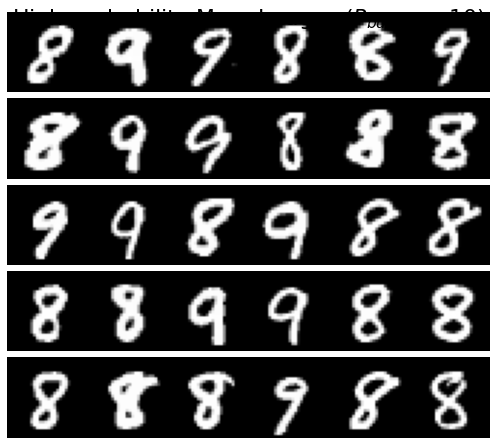

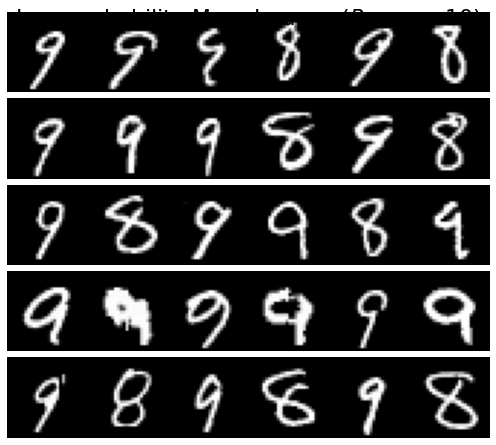

In [12]:
P_idx = 0

indsort = np.argsort(softmax(all_train_dist[P_idx]))[::-1]

fig, axs = plt.subplots(5,6, figsize=(7,6.3)) 
for j, a in enumerate(axs.flatten()):
    a.imshow(X[indsort[j]].reshape((28,28)), cmap = 'gray')
    a.axis('off')
fig.suptitle('High-probability Mass Images ($P_{budget}=%d$)'%Pvals[P_idx], fontsize=22)
plt.tight_layout()
plt.subplots_adjust(wspace =0,hspace=0)
plt.savefig(root_dir + 'fixed_test_best_digits_P=%d.pdf'%Pvals[P_idx])
plt.show()

fig, axs = plt.subplots(5,6, figsize=(7,6.3)) 
for j, a in enumerate(axs.flatten()):
    a.imshow(X[indsort[::-1][j]].reshape((28,28)), cmap = 'gray')
    a.axis('off')
fig.suptitle('Low-probability Mass Images ($P_{budget}=%d$)'%Pvals[P_idx], fontsize=22)
plt.tight_layout()
plt.subplots_adjust(wspace =0,hspace=0)
plt.savefig(root_dir + 'fixed_test_worst_digits_P=%d.pdf'%Pvals[P_idx])
plt.show()


In [12]:
#Pvals = [2.0, 5.0, 10.0, 20.0, 50.0, 100.0]
Pvals_expt = np.linspace(5, 200, 10)
Pvals_dense = np.linspace(5, 200, 50)

all_expt_avg = []
all_expt_std = []

all_theory = []

num_repeat = 500

err_old,std_old = kr_expt_measure_train(Pvals_expt, np.ones(K.shape[0])/K.shape[0], K, y_vec, lamb, num_repeat = num_repeat)
theory_curves_old = [Eg_wrt_train(jnp.ones(K.shape[0]), (K, y_vec,int(P), lamb)) for P in Pvals_dense]

for i, state in enumerate(all_train_dist):
    err_new, std_new = kr_expt_measure_train(Pvals_expt, np.array(softmax(state)), K, y_vec, lamb, num_repeat = num_repeat)
    theory_curves = [Eg_wrt_train(state, (K, y_vec, int(P), lamb)) for P in Pvals_dense]
    all_expt_avg += [err_new]
    all_expt_std += [std_new]
    all_theory += [theory_curves]


In [ ]:
idx_set = [0,1,2]
for i, theory_i in zip(idx_set, np.array(all_theory)[idx_set]):
    plt.plot(Pvals_dense[(theory_i<1)*(theory_i>0)], np.array(theory_i)[(theory_i<1)*(theory_i>0)], color = 'C%d' % i)
    plt.errorbar(Pvals_expt, all_expt_avg[i], all_expt_std[i], fmt='o', color = 'C%d' % i, label =r'Optimized $P = %d$' % Pvals[i] )

plt.plot(Pvals_dense, np.array(theory_curves_old), color = 'black', label = 'Original Uniform Measure')
plt.errorbar(Pvals_expt, err_old, std_old, fmt='o' , color = 'black')
plt.xlabel(r'$P$',fontsize = 20)
plt.ylabel(r'$E_g$', fontsize=20)
plt.legend()

plt.tight_layout()
plt.savefig(root_dir + 'fixed_test_generalization.pdf')
plt.show()